In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
from DiRect import *

# Trivial 1-D Example

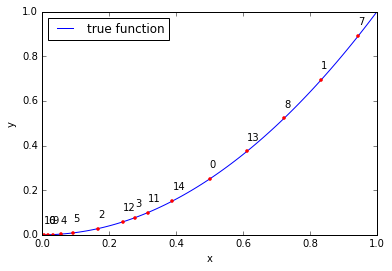

In [2]:
func_1d = lambda x: (x**2)[0] # f: vector to scalar
b = np.array([[0,1]])
direct = DiRect(func_1d, b, max_iter=4)
direct.run()
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100).reshape((1,-1))
y = func_1d(x)
plt.plot(x.flatten(),y, label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1

# Non-Trivial 1D

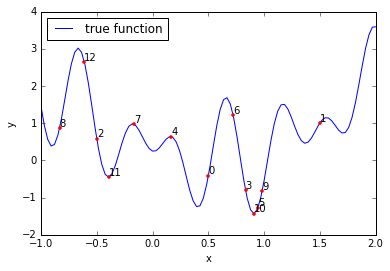

In [3]:
def func_1d(x):
    return ((x-0.5)**2 + np.sin(x*2.1)* np.sin(x*12)*1.7)
b = np.array([[-1,2]])
direct = DiRect(func_1d, b, max_feval=12)
direct.run()
plt.figure()
x = np.linspace(b[0,0], b[0,1], 100)
y = np.array([func_1d(xx) for xx in x])
true_opt = np.min(y)
plt.plot(x.flatten(),y, label='true function')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
i = 0
for hist in direct.l_hist:
    plt.plot(hist[0], hist[1], 'r.')
    plt.text(hist[0], hist[1]+0.05, i)
    i += 1
    

## Performance versus random search

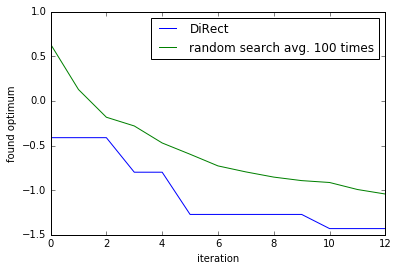

In [9]:
h = np.array([yy for xx, yy in direct.l_hist])
search = np.minimum.accumulate(h)

nRand = 100
rand_search = np.zeros((search.shape[0],))
for ii in xrange(nRand):
    np.random.shuffle(y)
    rand_search += np.minimum.accumulate(y[:search.shape[0]])
rand_search /= float(nRand)
plt.plot(search, label='DiRect')
plt.plot(rand_search, label='random search avg. 100 times')
plt.legend(loc='best')
plt.xlabel('iteration')
plt.ylabel('found optimum')